In [218]:
pip install numpy --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [219]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [220]:
pip install "modin[all]" # (Recommended) Install Modin with all of Modin's currently supported engines.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [221]:
import modin.pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import Lasso
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [222]:
path = "asylum_seekers.csv"
data = pd.read_csv(path)

# feature engineering

In [223]:
#data = pd.read_csv('asylum_seekers.csv')

data.head()

cols_to_convert = ['Tota pending start-year', 'Applied during year', 'decisions_recognized', 'decisions_other', 'Rejected']
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')


data['E+G'] = data['Tota pending start-year'] + data['Applied during year']
data['acceptance_rate'] = data['decisions_recognized'] / data['E+G']
data['decision_pending_rate'] = data['decisions_other'] / data['E+G']
data['rejection_rate'] = data['Rejected'] / data['E+G']

data[['Year', 'Tota pending start-year', 'Applied during year', 'E+G', 'acceptance_rate', 'decision_pending_rate', 'rejection_rate']].head()

,Year,Tota pending start-year,Applied during year,E+G,acceptance_rate,decision_pending_rate,rejection_rate
0,2000,0.0,5.0,5.0,1.000000,0.0,0.000000
1,2000,8.0,0.0,8.0,0.000000,0.0,0.000000
2,2000,265.0,2156.0,2421.0,0.308550,0.0,0.046262
3,2000,196.0,225.0,421.0,0.358670,0.0,0.073634
4,2000,193.0,218.0,411.0,0.442822,0.0,0.124088


In [224]:
print(data.isnull().sum())

Year                                           0
Country / territory of asylum/residence        0
Origin                                         0
RSD procedure type / level                     1
Tota pending start-year                     8173
of which UNHCR-assisted(start-year)        10758
Applied during year                         6857
decisions_recognized                       11314
decisions_other                            15370
Rejected                                   10402
Otherwise closed                            8870
Total decisions                            32638
Total pending end-year                      3888
of which UNHCR-assisted(end-year)           7837
E+G                                        11068
acceptance_rate                            19066
decision_pending_rate                      21883
rejection_rate                             16332
dtype: int64


In [225]:
#print(data[data['Tota pending start-year'].isnull()])
data_cleaned = data.dropna()

In [226]:
data_cleaned = data_cleaned.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [227]:
label_encoder = LabelEncoder()
data_cleaned['Country / territory of asylum/residence encoded'] = label_encoder.fit_transform(data_cleaned['Country / territory of asylum/residence'])
data_cleaned['Origin encoded'] = label_encoder.fit_transform(data_cleaned['Origin'])
data_cleaned['RSD procedure type / level encoded'] = label_encoder.fit_transform(data_cleaned['RSD procedure type / level'])

In [228]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80064 entries, 0 to 129680
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Year                                             80064 non-null  int64  
 1   Country / territory of asylum/residence          80064 non-null  object 
 2   Origin                                           80064 non-null  object 
 3   RSD procedure type / level                       80064 non-null  object 
 4   Tota pending start-year                          80064 non-null  float64
 5   of which UNHCR-assisted(start-year)              80064 non-null  object 
 6   Applied during year                              80064 non-null  float64
 7   decisions_recognized                             80064 non-null  float64
 8   decisions_other                                  80064 non-null  float64
 9   Rejected                        

In [229]:
data_cleaned['Total decisions'] = pd.to_numeric(data_cleaned['Total decisions'], errors='coerce')
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80064 entries, 0 to 129680
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Year                                             80064 non-null  int64  
 1   Country / territory of asylum/residence          80064 non-null  object 
 2   Origin                                           80064 non-null  object 
 3   RSD procedure type / level                       80064 non-null  object 
 4   Tota pending start-year                          80064 non-null  float64
 5   of which UNHCR-assisted(start-year)              80064 non-null  object 
 6   Applied during year                              80064 non-null  float64
 7   decisions_recognized                             80064 non-null  float64
 8   decisions_other                                  80064 non-null  float64
 9   Rejected                        

# EDA

### Top 10 Countries of Origin with Highest Number of Refugees

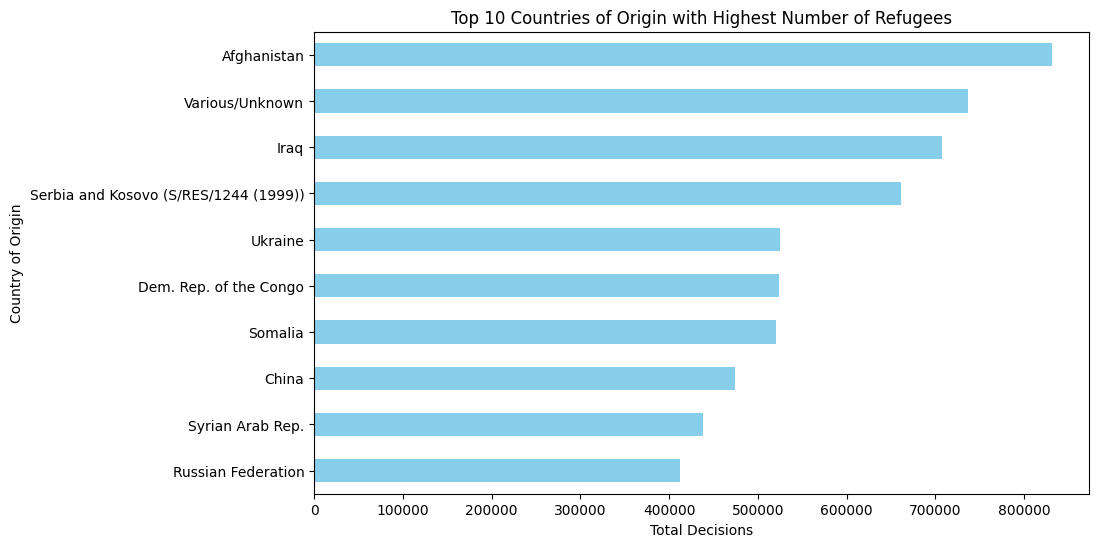

In [230]:
#Grouping by 'Origin' and summing up the 'Total decisions' to identify the country of origin with the highest number of refugees
origin_refugees = data_cleaned.groupby('Origin')['Total decisions'].sum().sort_values(ascending=False)

#data_cleaned['Total decisions'] = pd.to_float(data_cleaned['Total decisions'], errors='coerce')


plt.figure(figsize=(10, 6))
origin_refugees.head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Countries of Origin with Highest Number of Refugees')
plt.xlabel('Total Decisions')
plt.ylabel('Country of Origin')
plt.gca().invert_yaxis()
plt.show()

### Distribution of Total Decisions for Top 5 Countries (2000-2016)

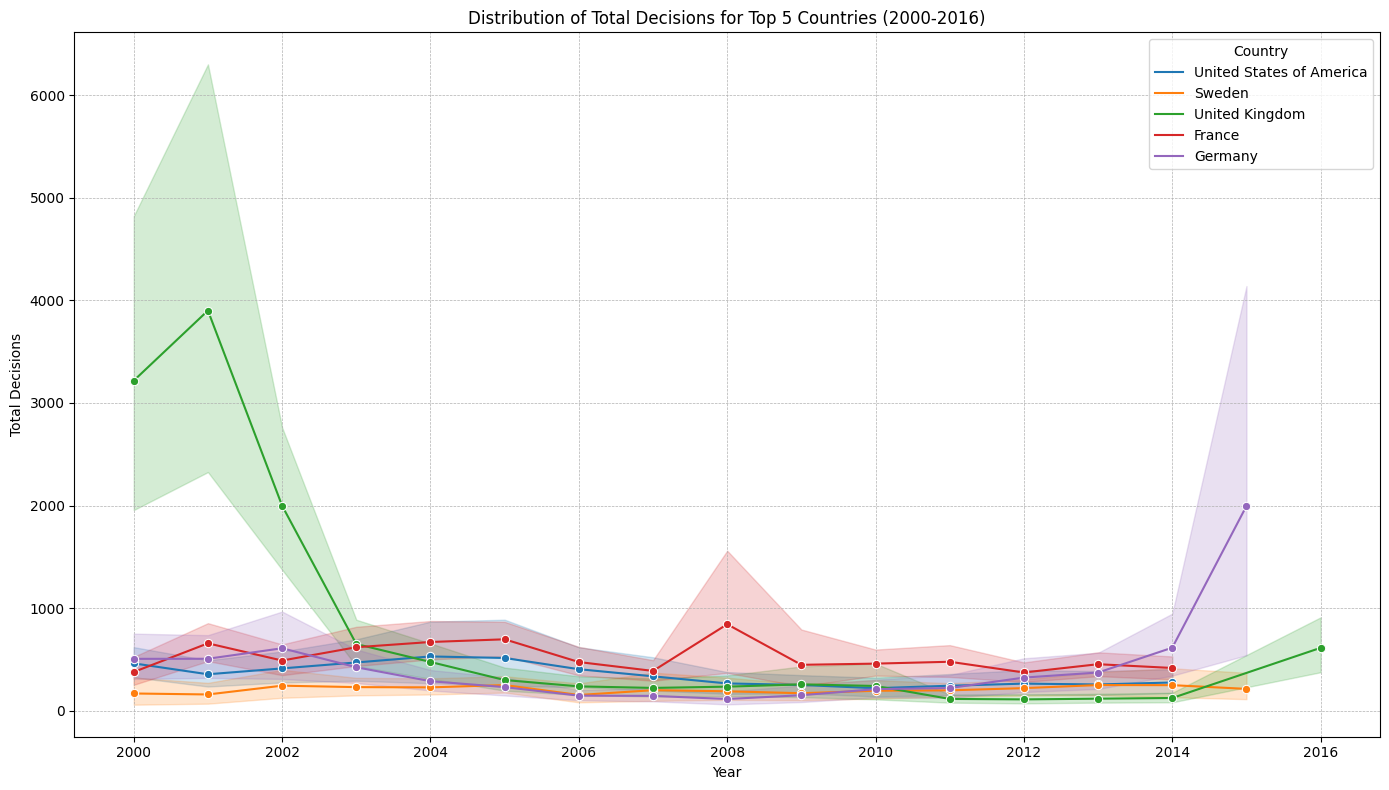

In [231]:
data_cleaned['Total decisions'] = pd.to_numeric(data_cleaned['Total decisions'], errors='coerce')
data_cleaned['Total decisions'].fillna(0, inplace=True)

# Identify the top 5 countries with the highest total decisions in data_cleaned
country_decisions_cleaned = data_cleaned.groupby('Country / territory of asylum/residence')['Total decisions'].sum()

top_5_countries_cleaned = country_decisions_cleaned.sort_values(ascending=False).head(5).index

df_top_5_countries_cleaned = data_cleaned[data_cleaned['Country / territory of asylum/residence'].isin(top_5_countries_cleaned)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_top_5_countries_cleaned, x='Year', y='Total decisions', hue='Country / territory of asylum/residence', marker='o')

plt.title('Distribution of Total Decisions for Top 5 Countries (2000-2016)')
plt.ylabel('Total Decisions')
plt.xlabel('Year')
plt.legend(title='Country')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### World maps for origin applications and Accepted countries where refuge is taken

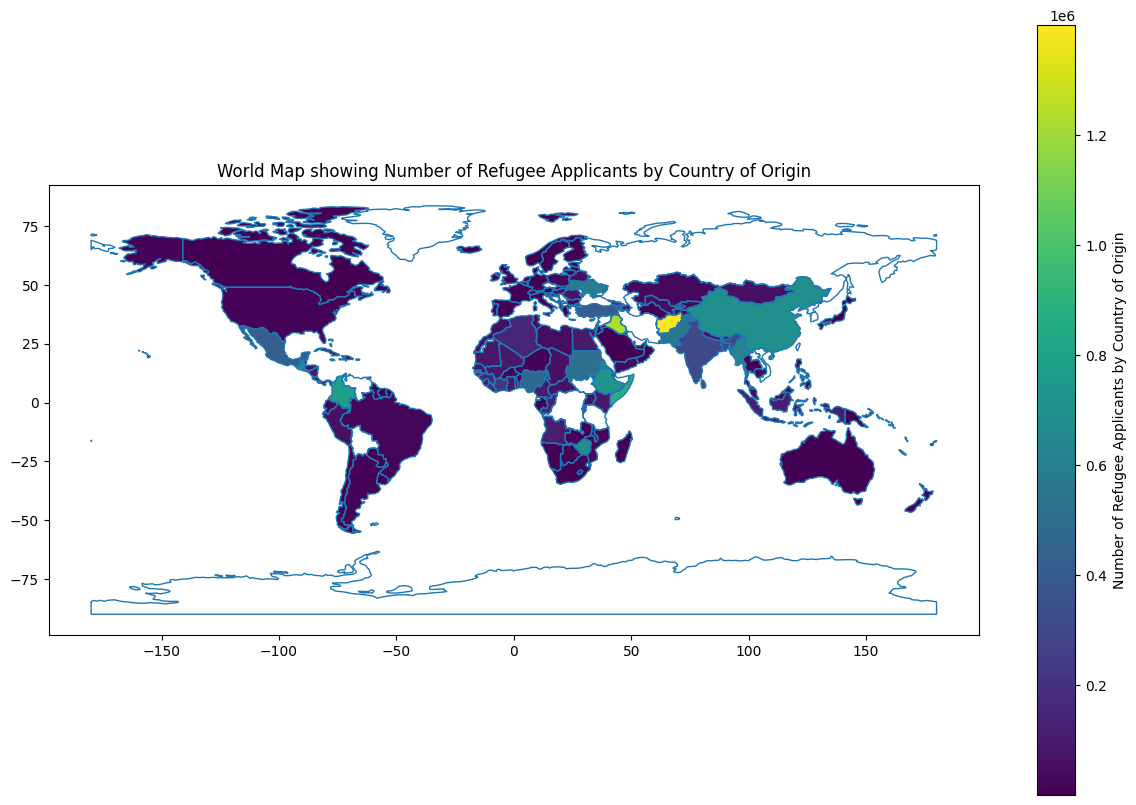

In [232]:
import geopandas as gpd
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data_cleaned['Total applicants'] = data_cleaned['Tota pending start-year'] + data_cleaned['Applied during year']
refugee_applicants_data = data_cleaned.groupby('Origin')['Total applicants'].sum().reset_index()
merged_applicants = world.set_index('name').join(refugee_applicants_data.set_index('Origin'))
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
merged_applicants.plot(column='Total applicants', ax=ax, legend=True,
                       legend_kwds={'label': "Number of Refugee Applicants by Country of Origin"})
plt.title('World Map showing Number of Refugee Applicants by Country of Origin')
plt.show()

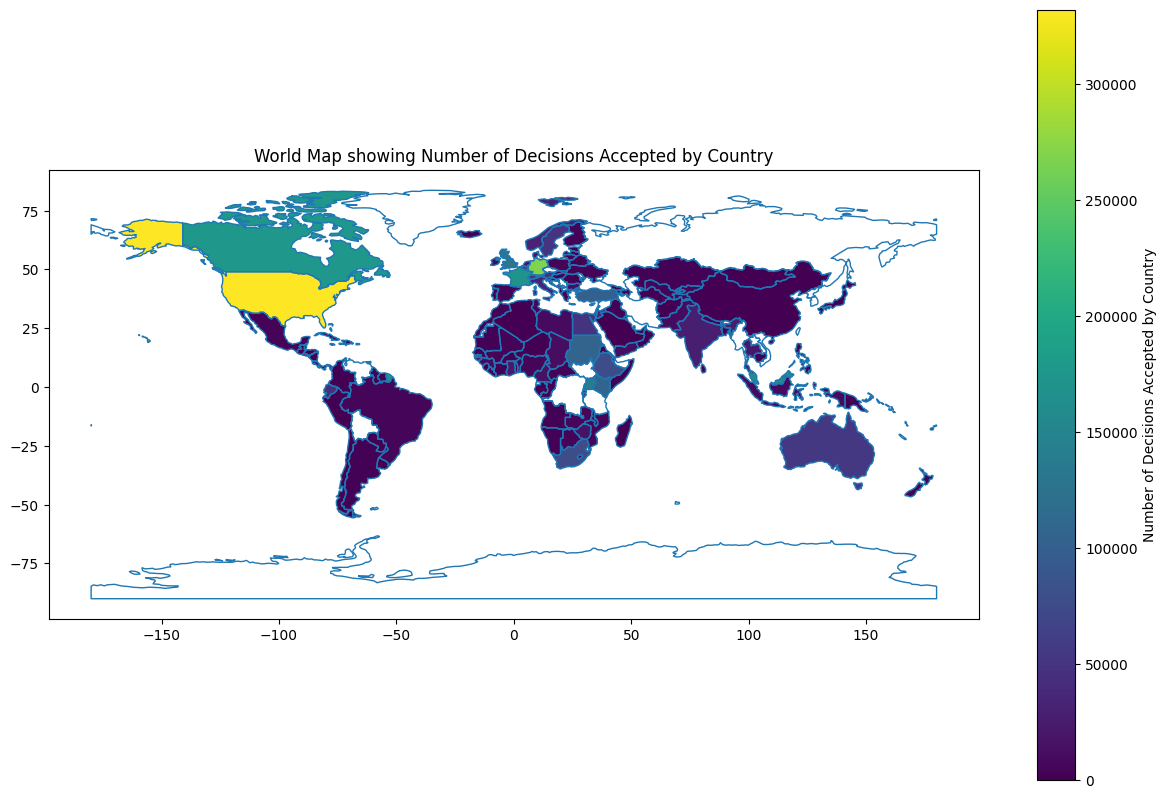

In [233]:
accepted_data = data_cleaned.groupby('Country / territory of asylum/residence')['decisions_recognized'].sum().reset_index()
merged_accepted = world.set_index('name').join(accepted_data.set_index('Country / territory of asylum/residence'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
merged_accepted.plot(column='decisions_recognized', ax=ax, legend=True,
                     legend_kwds={'label': "Number of Decisions Accepted by Country"})
plt.title('World Map showing Number of Decisions Accepted by Country')
plt.show()

In [234]:
selected_columns = [ 'Country / territory of asylum/residence encoded', 'Origin encoded', 'RSD procedure type / level encoded']
x = data_cleaned[selected_columns]
x.shape

(80064, 3)

In [235]:
y = data_cleaned['acceptance_rate']
y.size

80064

# model building

# Polynomial regression

In [236]:
# Implementing polynomial regression
# Transform Data to Polynomial Features
degree = 8  # You can adjust the degree as required
polynomial_features = PolynomialFeatures(degree=degree)
X_poly = polynomial_features.fit_transform(x)

# Apply Linear Regression on Transformed Data
model = LinearRegression()
model.fit(X_poly, y)
y_poly_pred = model.predict(X_poly)

# Compute the RMSE to check the performance
rmse = np.sqrt(np.mean((y - y_poly_pred) ** 2))
#print(f"Root Mean Squared Error: {rmse}")
# RMSE value is 0.39 for degree 6
mae = np.mean(abs(y - y_poly_pred))
# Calculate metrics
#rmse = np.sqrt(mean_squared_error(y_test, y_poly_pred))
#mae = mean_absolute_error(y_test, y_poly_pred)
#r2 = r2_score(y_test, y_poly_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
#print(f"R^2: {r2}")


RMSE: 0.39932409798551743
MAE: 0.16277598604150684


# polynomial regression with cross validation

In [237]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Generate some sample data
#X, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=42)

# Create polynomial features
degree = 4  # adjust as needed
poly = PolynomialFeatures(degree)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create a polynomial regression model
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Perform k-fold cross-validation
k = 10
cross_val_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='neg_mean_squared_error')

# Convert negative MSE to RMSE
rmse_scores = np.sqrt(-cross_val_scores)

print(f"Mean RMSE for {k}-fold CV: {np.mean(rmse_scores)}")
print(f"Std deviation of RMSE for {k}-fold CV: {np.std(rmse_scores)}")

# Train the model on the entire training set and evaluate on the test set
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE on test set: {test_rmse}")

# Check for overfitting
if test_rmse > np.mean(rmse_scores) + np.std(rmse_scores):
    print("The model might be overfitting!")
else:
    print("The model seems fine!")


Mean RMSE for 10-fold CV: 0.38240986199746796
Std deviation of RMSE for 10-fold CV: 0.05105008525361091
RMSE on test set: 0.4673652429455474
The model might be overfitting!


# random forest with average voting

In [238]:
# Sample data
#X, y = # Your data here

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train the Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Collect predictions from each tree
all_predictions = np.array([tree.predict(X_test) for tree in rf.estimators_])

# Calculate the average prediction for each sample
avg_prediction = all_predictions.mean(axis=0)

# Compute RMSE
#rmse = np.sqrt(mean_squared_error(y_test, avg_prediction))

#print(f"RMSE: {rmse}")
#The computed rmse value should match (or be very close to) the RMSE obtained when using rf.predict(X_test) directly, as the

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, avg_prediction))
mae = mean_absolute_error(y_test, avg_prediction)
r2 = r2_score(y_test, avg_prediction)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")


RMSE: 0.44598977625213965
MAE: 0.13261088031819185
R^2: 0.09722094098364875


# Random forest

In [239]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Sample data
#X, y = # Your data here

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train the Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

RMSE: 0.44598977625213965
MAE: 0.13261088031819185
R^2: 0.09722094098364875


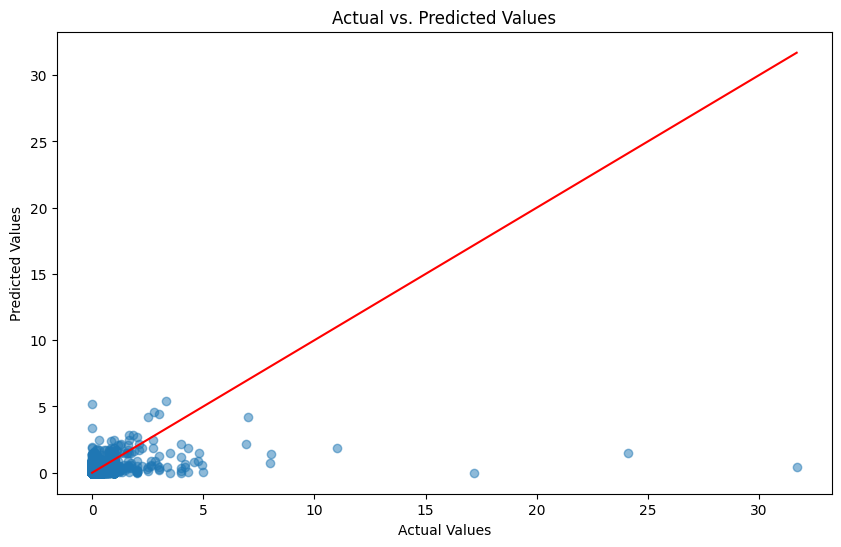

In [240]:
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# XGBoost

In [241]:
import xgboost as xgb
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")


RMSE: 0.4393558702988217
MAE: 0.13703082547652334


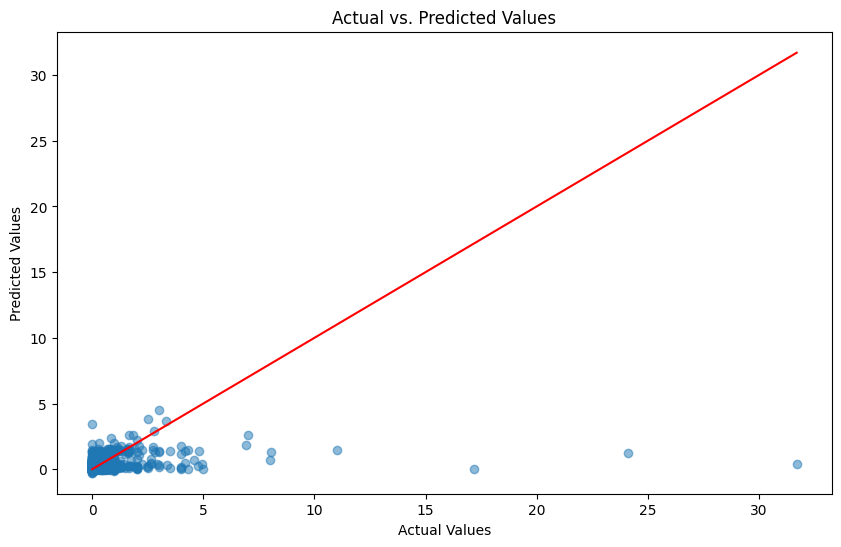

In [242]:
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

In [243]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [244]:
print(torch.backends.mkldnn.is_available())

True


In [245]:
!export MKLDNN_VERBOSE=2

In [246]:
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.to_numpy())
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.to_numpy())


# Create DataLoader for training and testing data
batch_size = 64
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Define the neural network model
class AcceptanceNet(nn.Module):
    def __init__(self, input_dim):
        super(AcceptanceNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model, define loss function and optimizer
model = AcceptanceNet(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (placeholder)
for epoch in range(10):  # Number of epochs is set to 10 as a placeholder. Adjust as needed.
    # Training code here
    pass

# Evaluation (placeholder)
# Model evaluation code here
    

In [247]:
from torch.utils.data import random_split

# Split the training data into training and validation datasets
train_size = int(0.8 * len(X_train_tensor))  # 80% for training
val_size = len(X_train_tensor) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# ... (rest of the code)


In [248]:
from copy import deepcopy

# Assume we already have a validation_loader, similar to train_loader and test_loader

# Parameters for early stopping
patience = 5
best_loss = float('inf')
counter = 0
best_model = None

# Training the model with early stopping
num_epochs = 20  # Increase this since early stopping might halt training prematurely
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            val_loss += loss.item()
    val_loss /= len(validation_loader)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

# Load best model weights
model.load_state_dict(best_model)

# Continue with the evaluation or other tasks...


Epoch [1/20], Train Loss: 1.1888, Val Loss: 0.1423
Epoch [2/20], Train Loss: 0.1812, Val Loss: 0.2018
Epoch [3/20], Train Loss: 0.1699, Val Loss: 0.1858
Epoch [4/20], Train Loss: 0.1662, Val Loss: 0.1453
Epoch [5/20], Train Loss: 0.1655, Val Loss: 0.1411
Epoch [6/20], Train Loss: 0.1631, Val Loss: 0.1405
Epoch [7/20], Train Loss: 0.1609, Val Loss: 0.1383
Epoch [8/20], Train Loss: 0.1589, Val Loss: 0.1429
Epoch [9/20], Train Loss: 0.1568, Val Loss: 0.1385
Epoch [10/20], Train Loss: 0.1556, Val Loss: 0.1382
Epoch [11/20], Train Loss: 0.1545, Val Loss: 0.1384
Epoch [12/20], Train Loss: 0.1542, Val Loss: 0.1382
Epoch [13/20], Train Loss: 0.1540, Val Loss: 0.1385
Epoch [14/20], Train Loss: 0.1539, Val Loss: 0.1383
Epoch [15/20], Train Loss: 0.1538, Val Loss: 0.1382
Early stopping!


<All keys matched successfully>